In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from matplotlib.colors import LogNorm
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
from photutils.psf import EPSFBuilder, EPSFStars, extract_stars
from astropy.nddata import NDData
from astropy.table import Table
import astropy.units as u
from scipy.signal.windows import tukey
import h5py

plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25}
pylab.rcParams.update(params)

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [2]:
def radial_profile(data, center):
    y,x = np.indices((data.shape)) # first determine radii of all pixels
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    ind = np.argsort(r.flat) # get sorted indices
    sr = r.flat[ind] # sorted radii
    sim = data.flat[ind] # image values sorted by radii
    ri = sr.astype(np.int32) # integer part of radii (bin size = 1)
    # determining distance between changes
    deltar = ri[1:] - ri[:-1] # assume all radii represented
    rind = np.where(deltar)[0] # location of changed radius
    nr = rind[1:] - rind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.float64) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rind[1:]] - csim[rind[:-1]] # sum for image values in radius bins
    radialprofile = tbin/nr # the answer
    return radialprofile

In [3]:
datapath = os.getenv("project") + "/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"
# datapath = "/media/alexandre/Seagate/Data/Horseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits"

data = fits.open(datapath)

In [4]:
pixel_scale = data["PRIMARY"].header["D001SCAL"]
pixel_scale # arcsec

0.0396200008690344

In [5]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4291                                                  
NAXIS2  =                 4649                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib4802tkq                         ' / rootname of the observation set
EXPNAME = 'ib4802tkq                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'     

In [6]:
data.info()

Filename: /home/alexandre/Desktop/Projects/data/CosmicHorseshoe/hst_11602_02_wfc3_uvis_f814w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1005   ()      
  1  SCI           1 ImageHDU        88   (4291, 4649)   float32   


In [7]:
exptime = data["PRIMARY"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime # data is now a count
# weights = data["WHT"].data

exposure time: 5592.0 s


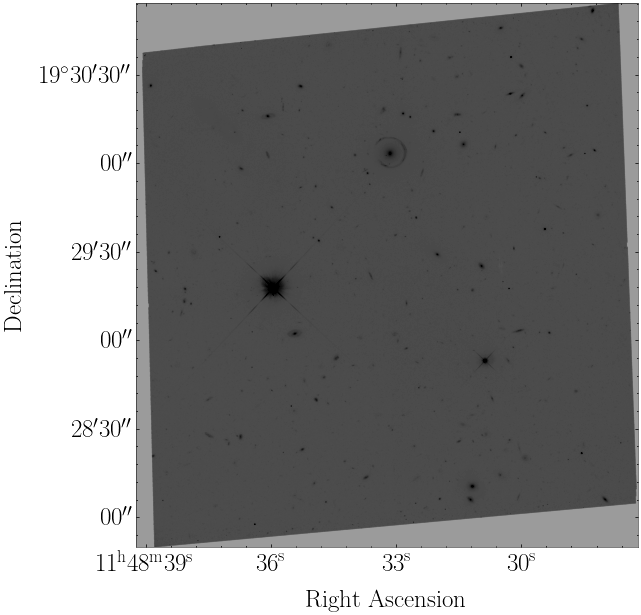

In [8]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=1000))
# plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination');

# Find a patch of dark sky to estimate noise

In [9]:
# Right ascension	11h 48m 33.1s
# Declination	19° 30′ 03″
centroid = SkyCoord(177.13808, 19.50089, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid # in pixel space

(array(2176.48364204), array(3361.47934944))

In [10]:
bkg_centroid = SkyCoord("11h48m30.1s", "+19.50089", unit=(u.hourangle, u.deg))
bkg_centroid = bkg_centroid.to_pixel(wcs)
x0, y0 = bkg_centroid
x1 = x0 - 150
x2 = x0 + 150
y1 = y0 - 150
y2 = y0 + 150
bkg_centroid # in pixel space

(array(3261.11020582), array(3361.52172117))

In [11]:
size = 300 * u.pixel
bkg_cutout = Cutout2D(image, bkg_centroid, size, wcs=wcs)
bkg_cutout_image = bkg_cutout.data
bkg_wcs_cutout = bkg_cutout.wcs
# cutout_image[cutout_image < 0] = 0

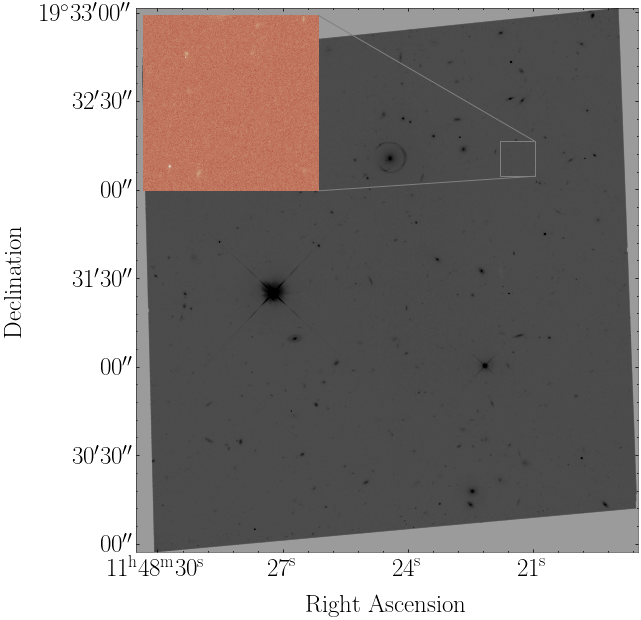

In [12]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
# plt.title("")
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=1000))

ax = plt.gca()
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
extent=[0, image.shape[1], 0, image.shape[0]]
axins = zoomed_inset_axes(ax, 5, loc=2) # zoom = 6
axins.imshow(image, interpolation="nearest", extent=extent, origin="lower", cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmax=500))
axins.axis("off")
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

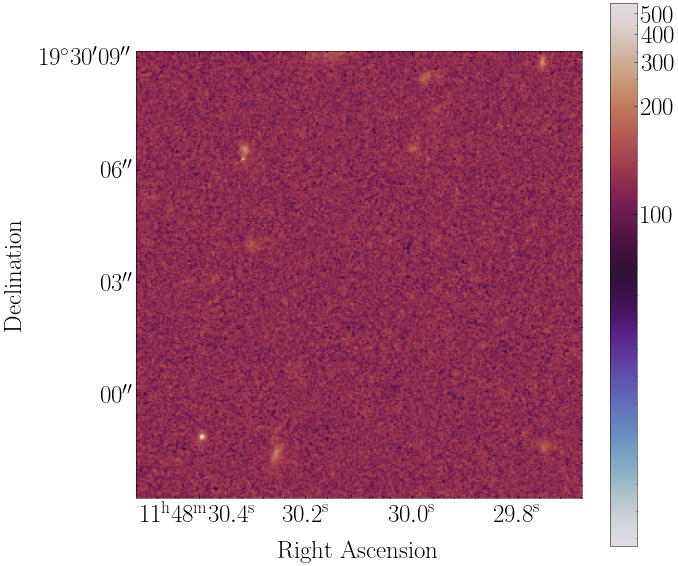

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=bkg_wcs_cutout)
plt.imshow(bkg_cutout_image , cmap="twilight", norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

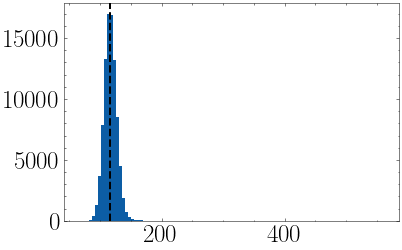

In [14]:
plt.hist(bkg_cutout_image.ravel(), bins=100);
plt.axvline(np.mean(bkg_cutout_image), ls="--", lw=2, color="k")

In [15]:
bkg = np.mean(bkg_cutout_image)
std_bkg = np.std(bkg_cutout_image)
bkg, std_bkg

(116.77832, 10.967095)

# Find PSF candidates around the Horseshoe

In [16]:
size = 3000 * u.pixel
psf_cutout = Cutout2D(image, centroid, size, wcs=wcs)
psf_cutout_image = psf_cutout.data
psf_wcs_cutout = psf_cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [17]:
daofind = DAOStarFinder(fwhm=1, threshold=200.*std_bkg)
sources = daofind(psf_cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
object_positions = sources["xcentroid", "ycentroid"].to_pandas().to_numpy()
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[1:5]

<QTable length=4>
  id      xcentroid      ...        flux                mag         
int64      float64       ...      float64             float64       
----- ------------------ ... ------------------ --------------------
    2   495.467112822597 ... 140.24084798809108   -5.367186322806959
    3 478.92047850262946 ... 1.7809638268919856  -0.6266377465234327
    4 509.10787121142295 ... 1.1337807499579176 -0.13632269748226994
    5  492.2633676040839 ...  91.91290886696453  -4.9084412772678405

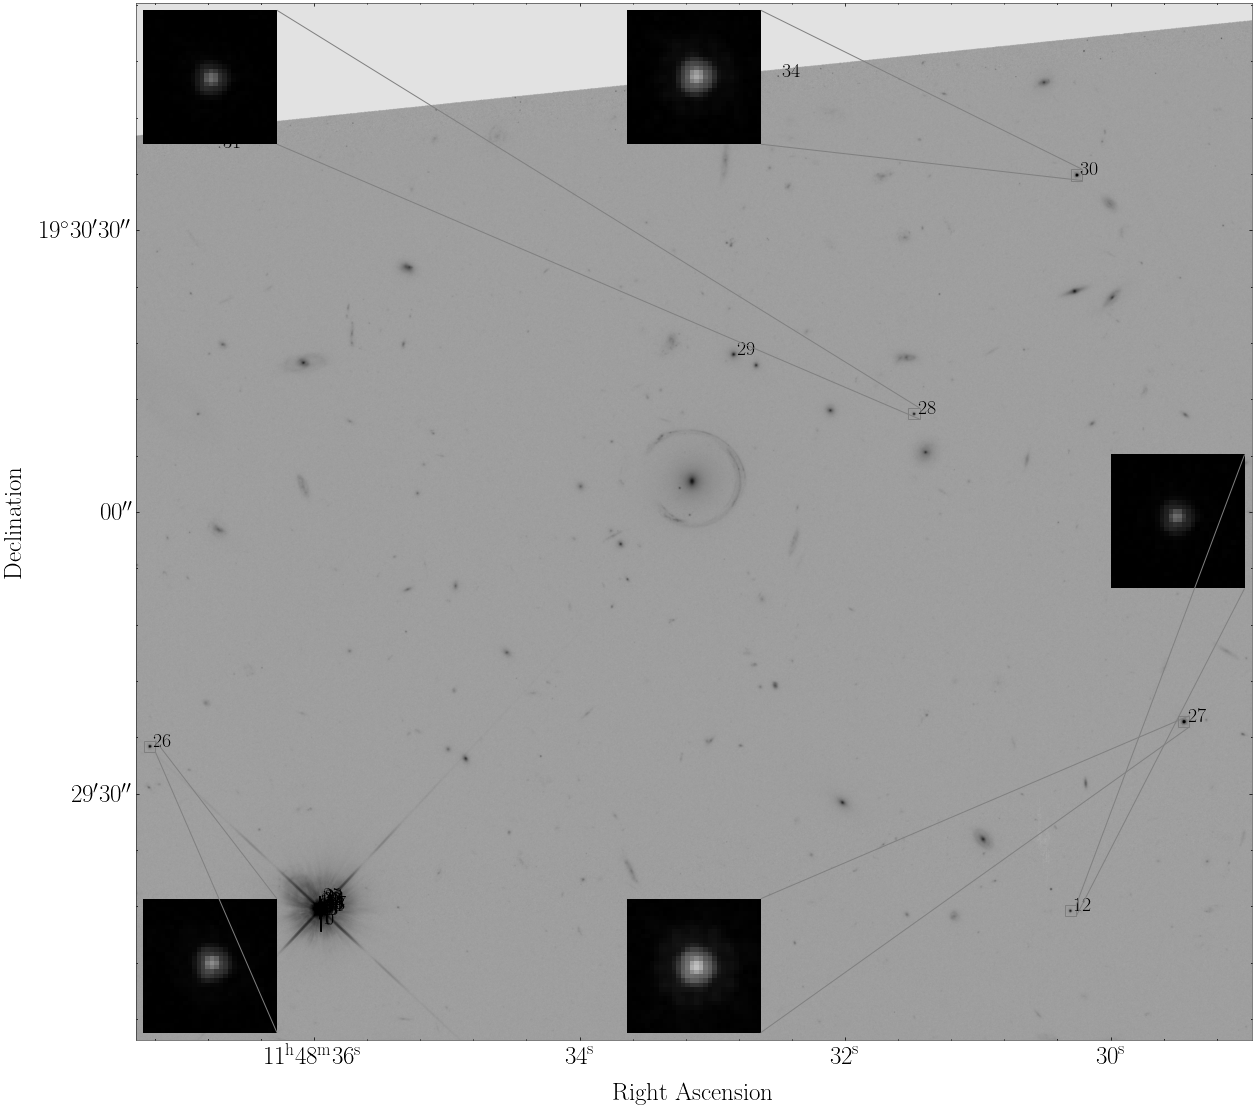

In [18]:
plt.figure(figsize=(20, 20))
plt.subplot(projection=psf_wcs_cutout)
# plt.title("")
plt.imshow(psf_cutout_image-bkg, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmax=10000))

ax = plt.gca()
for i in range(len(sources)):
    ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="k", fontsize=20)


extent=[0, psf_cutout_image.shape[1], 0, psf_cutout_image.shape[0]]

d = 15


k = 28
axins = zoomed_inset_axes(ax, 12, loc=2) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 30
axins = zoomed_inset_axes(ax, 12, loc=9) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

# k = 28
k = 26
axins = zoomed_inset_axes(ax, 12, loc=3) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 27
axins = zoomed_inset_axes(ax, 12, loc=8) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

k = 12
axins = zoomed_inset_axes(ax, 12, loc=7) # zoom = 6
axins.imshow(np.maximum(psf_cutout_image - bkg, 0), interpolation="nearest", extent=extent, origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x0, y0 = ox[k], oy[k]
x1, y1 = ox[k] - d, oy[k] - d
x2, y2 = ox[k] + d, oy[k] + d
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5");

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

## Fit an effective PSF based on the candidates found

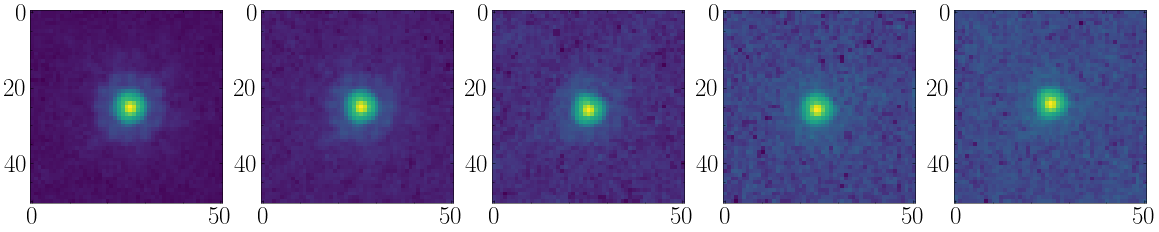

In [19]:
indices = [27, 30, 26, 12, 28]
stars = []
stars_tbl = Table()
stars_tbl['x'] = [0,]*len(indices)
stars_tbl['y'] = [0,]*len(indices)
nddata = NDData(data=psf_cutout_image - bkg)
for j, i in enumerate(indices):
    stars_tbl['x'][j] = ox[i]
    stars_tbl['y'][j] = oy[i]
#     x, y = np.round(ox[i]), np.round(oy[i])
#     size = 50 * u.pixel
#     stars.append(np.maximum(Cutout2D(psf_cutout_image, (psf_x, psf_y), size, wcs=wcs).data - bkg, 0))

stars = extract_stars(nddata, stars_tbl, size=50)


fig, axs = plt.subplots(1, len(stars), figsize=(4*len(stars), 4))
for i in range(len(stars)):
    axs[i].imshow(stars[i], norm=ImageNormalize(stretch=LogStretch()))

In [20]:
epsf_builder = EPSFBuilder(oversampling=1, maxiters=10, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)
psf = np.maximum(epsf.data, 0)
psf /= psf.sum()

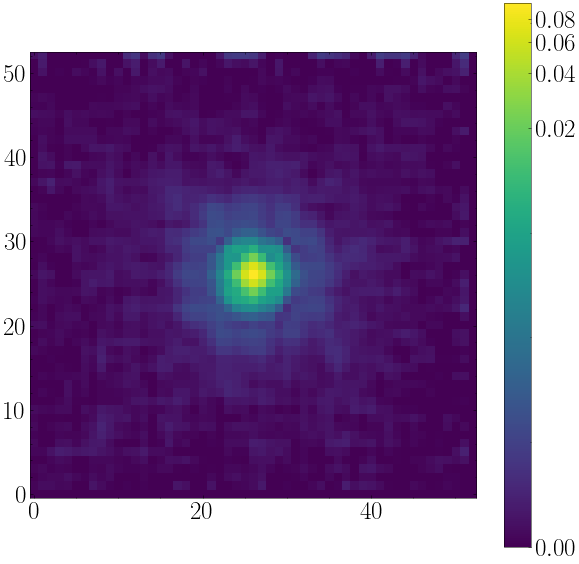

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(psf, norm=ImageNormalize(stretch=LogStretch()), origin='lower', cmap='viridis')
plt.colorbar()
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=psf, header=psf_wcs_cutout.to_header()))
new_hdul.writeto("../data/horseshoe_epsf.fits", overwrite=True)

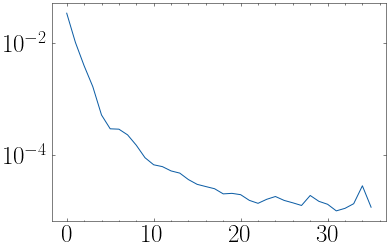

In [22]:
center = (psf.shape[0]/2,)*2
plt.plot(radial_profile(psf, center))
plt.yscale("log")
# plt.axhline(14)

# Make the Horshoe cutout

In [23]:
size = 350* u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
# cutout_image[cutout_image < 0] = 0

In [24]:
daofind = DAOStarFinder(fwhm=3.0, threshold=200)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[3, 1, 2]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # G, 01, 02
ox, oy = object_positions[:, 0], object_positions[:, 1]

sources[[3, 1, 2]]

<QTable length=3>
  id      xcentroid      ...        flux                mag        
int64      float64       ...      float64             float64      
----- ------------------ ... ------------------ -------------------
    4 168.68183739073956 ...  6.282358047507986 -1.9953067107777445
    2 163.04956087623586 ... 2.7737428695999147 -1.1076654970254516
    3 136.10978496262558 ...  5.989953025687427 -1.9435585414637901

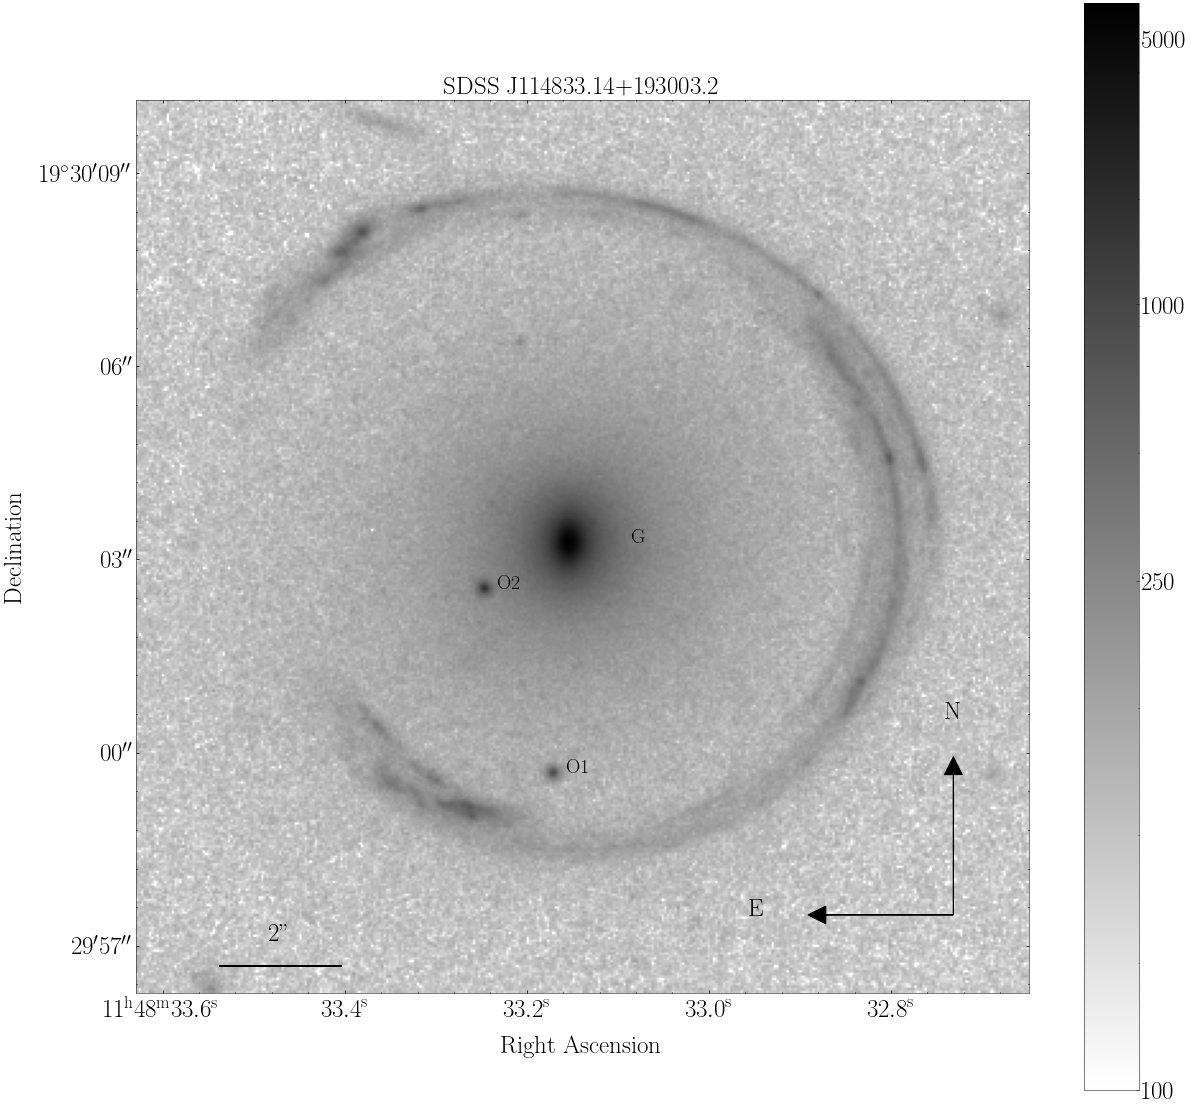

In [26]:
color="k"
plt.figure(figsize=(20, 20))
plt.subplot(projection=wcs_cutout)
# plt.imshow(mask * (cutout_image - bkg) + noise, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()))
# plt.imshow((cutout_image - bkg)/noise_std, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0))
plt.imshow(cutout_image, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch(), vmin=100))


ax = plt.gca()
plt.colorbar(ax=ax, ticks=[100, 250, 1000, 5000])


ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

# for i in range(len(sources)):
#     ax.annotate(f"{i}",  [ox[i]+10, oy[i]], color="r", fontsize=20)
ax.annotate("G",  [ox[0]+25, oy[0]], color=color, fontsize=20)
ax.annotate("O1",  [ox[1]+5, oy[1]], color=color, fontsize=20)
ax.annotate("O2",  [ox[2]+5, oy[2]], color=color, fontsize=20)
# ax.annotate("O3",  [ox[3]+10, oy[3]], color="r", fontsize=20)



N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
FOV = x.max().value()
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#coordinate array
arrow_size = 0.02
font_size = 25
width = cutout_image.shape[0]
d0 = 30
p0 = 50
pt = 70

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + 1.1*p0
xx_ra_t, yy_ra_t = xx_ - 1.1*pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + 1.1*pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

#scale bar
p0 = 80
dist = 2 / deltaPix
ax.plot([p0, p0 + dist], [10, 10], linewidth=2, color=color)
ax.text(p0 + dist / 2., 20, "2''", fontsize=font_size, color=color, ha='center')

ax.set_title("SDSS J114833.14+193003.2");
plt.savefig("horseshoe.png")

# Galfit G, O1 and O2

## Prepare mask

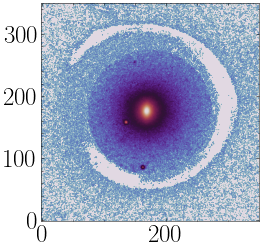

In [28]:
noise_std = np.sqrt(np.abs(std_bkg**2 + np.abs(cutout_image)))
im = (cutout_image - bkg)
x = np.linspace(-1, 1, im.shape[0]) * im.shape[0]/2
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = (r < 100) | (im < 2*noise_std)
plt.imshow(im * mask, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0), origin="lower")
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(data=(~mask).astype(int), header=wcs_cutout.to_header())) # 1 means mask pixel, so we invert the values in fit
new_hdul.writeto("../data/horseshoe_galfit_mask.fits", overwrite=True)

In [29]:
new_hdul = fits.HDUList()
header = wcs_cutout.to_header()
header["EXPTIME"] = exptime
header["GAIN"] = 1.54
new_hdul.append(fits.PrimaryHDU(data=cutout_image - bkg, header=header)) # Make sure units is flux (normalize by exposure time)
new_hdul.writeto("../data/horseshoe_data_512_cutout.fits", overwrite=True)

In [30]:
new_hdul = fits.HDUList()
header = wcs_cutout.to_header()
header["EXPTIME"] = exptime
header["GAIN"] = 1.54
new_hdul.append(fits.PrimaryHDU(data=noise_std, header=header)) # Make sure units is flux (normalize by exposure time)
new_hdul.writeto("../data/horseshoe_sigma_image.fits", overwrite=True)

In [6]:
galfit = fits.open("../data/horseshoe_galfit.fits")

FileNotFoundError: [Errno 2] No such file or directory: '../data/horseshoe_galfit.fits'

In [182]:
model = galfit[2].data
residual = galfit[3].data

In [183]:
#parameters
galfit[2].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  350 / Length of data axis 1                          
NAXIS2  =                  350 / Length of data axis 2                          
OBJECT  = 'model   '           / Component type                                 
COMMENT ========== GALFIT Input Parameters ==========                           
INITFILE= 'galfit.feedme'      / GALFIT input file                              
DATAIN  = '../data/horseshoe_data_512_cutout.fits' / Input data image           
SIGMA   = '../data/horseshoe_sigma_image.fits' / Input sigma image              
PSF     = '../data/horseshoe_epsf.fits ' / Convolution PSF and kernel           
CONSTRNT= 'constraints.constraints' / Parameter constraint file                 
MASK    = '../data/horseshoe

Text(0.5, 1.0, 'Residual')

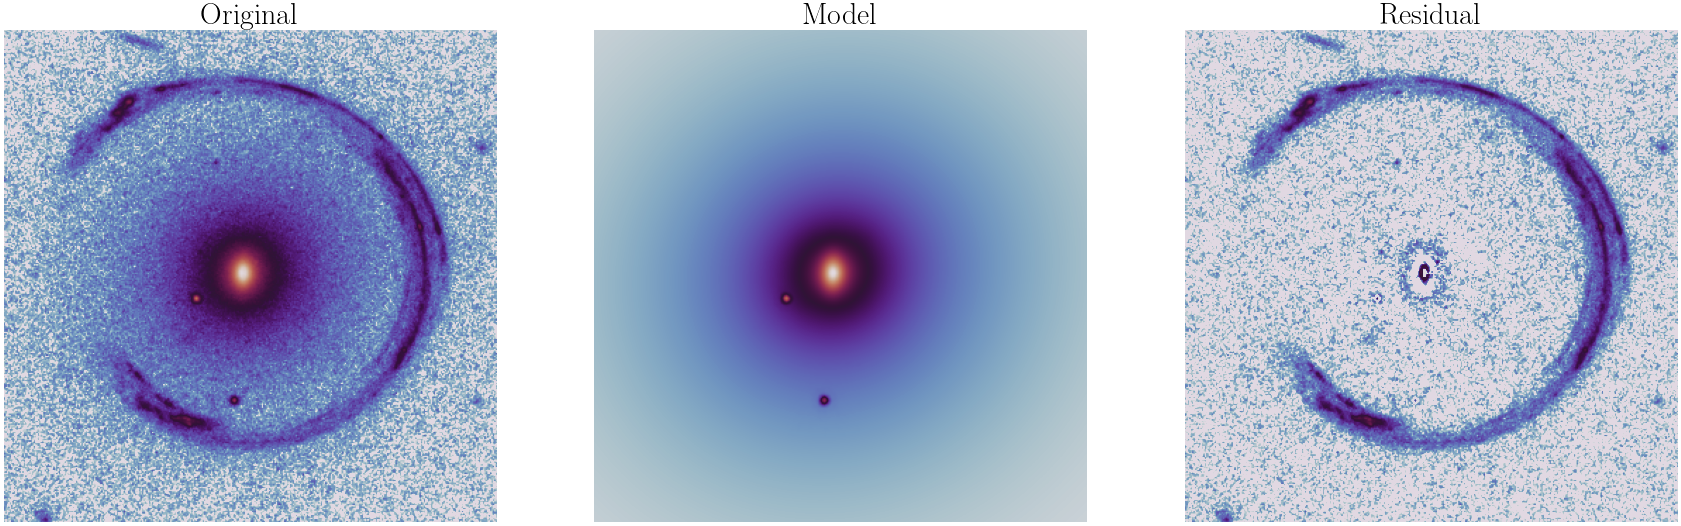

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].imshow(im,       cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0, vmax=7000), origin="lower")
axs[1].imshow(model,    cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0, vmax=7000), origin="lower")
axs[2].imshow(residual, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0, vmax=7000), origin="lower")
for ax in axs:
    ax.axis("off")
axs[0].set_title("Original", fontsize=30)
axs[1].set_title("Model", fontsize=30)
axs[2].set_title("Residual", fontsize=30)

# Prepare the data for RIM

### First, remove outliers in the data. Fold negative pixels back to the mean to preserve sky statistics 

In [185]:
residual[residual < -5 * std_bkg] = 0.

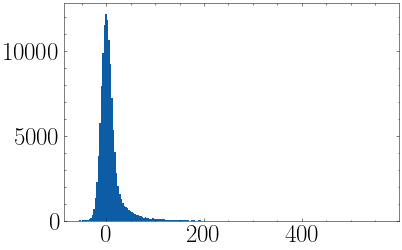

In [186]:
plt.hist(residual.ravel(), bins=200);

### Noise pad the light clumps inside and outside the ring

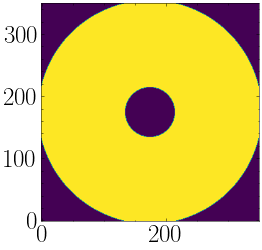

In [216]:
mask = (r > 180) #& (residual > 1.5*std_bkg)
mask += (r < 40) #& (residual > 2*noise_std)
mask = (~mask).astype(np.float32)
plt.imshow(mask, origin="lower")

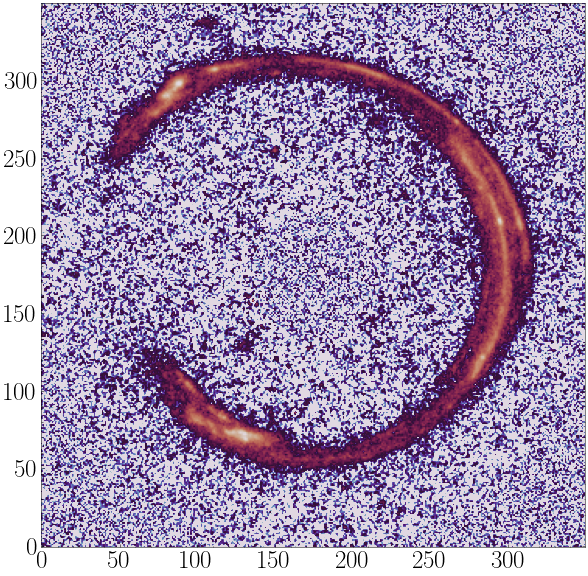

In [204]:
noise_mask = np.random.normal(scale=std_bkg, size=residual.shape)
residual_temp = residual * mask.astype(np.float32) # set offending pixels to 0
residual_temp += noise_mask * (1 - mask).astype(np.float32)
plt.figure(figsize=(10, 10))
plt.imshow(residual_temp, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=0), origin="lower")

### Prepare image to input into the RIM (only used to start up the recurrent inference, likelihood is computed in original data space)

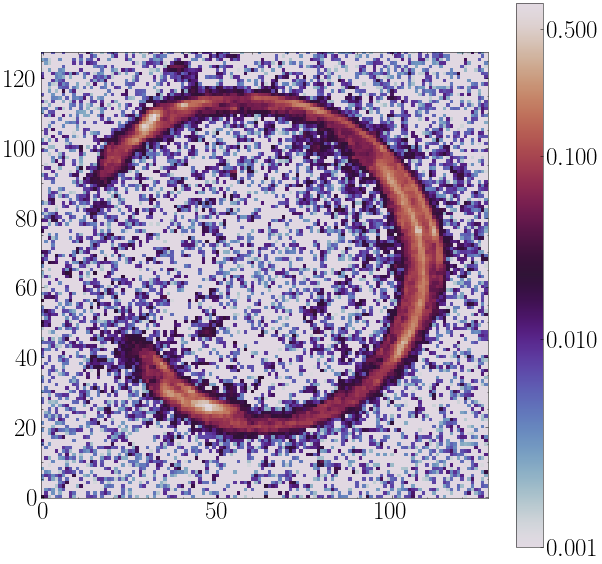

In [205]:
from skimage.transform import resize
rim_input = residual_temp / residual_temp.max() # normalize input
rim_input = resize(rim_input, (128, 128)) # resize to model expected shape
plt.figure(figsize=(10, 10))
plt.imshow(rim_input, cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-3), origin="lower")
plt.colorbar(ticks=[0.5, 0.1, 0.01, 1e-3])

# RIM prediction

In [206]:
from censai import RIMSharedUnetv3, PhysicalModelv2, PowerSpectrum
from censai.models import SharedUnetModelv4
import tensorflow as tf
import json

In [269]:
phys = PhysicalModelv2( # use same parameter as was used during training, rescale kappa later
    pixels=350,
    kappa_pixels=128,
    src_pixels=128,
    image_fov=FOV,
    kappa_fov=FOV,
    src_fov=4,
    method="fft",
)

In [270]:
path = "/media/alexandre/Seagate/Ecole/Automne2021/Censai/models/RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839"
with open(os.path.join(path, "unet_hparams.json")) as f:
    unet_params = json.load(f)
# unet_params["kernel_l2_amp"] = args.l2_amp
unet = SharedUnetModelv4(**unet_params)
ckpt = tf.train.Checkpoint(net=unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, path, 1)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()
with open(os.path.join(path, "rim_hparams.json")) as f:
    rim_params = json.load(f)
rim_params["source_link"] = "relu"
rim = RIMSharedUnetv3(phys, unet, **rim_params)

In [271]:
observation = tf.constant(residual / residual.max(), dtype=tf.float32)[None, ..., None]
lens_light = tf.constant(model, dtype=tf.float32)[None, ..., None]
rim_input1 = tf.constant(rim_input, dtype=tf.float32)[None, ..., None]
psf1 = tf.constant(psf, dtype=tf.float32)[None, ..., None]
noise_rms = tf.constant(std_bkg / residual.max())[None] # same scaling as before  --> make sure rim call support the sigma image
mask1 = tf.constant(mask, dtype=tf.float32)[None, ..., None]

## Patch up prediction function to take into account different shape of image as rim input and in the likelihood + lens light

In [272]:
from tqdm import tqdm
DTYPE = tf.float32
def predict(self, observation, noise_rms, psf, rim_input):#, lens_light):
    """
    Used in inference. Return physical kappa and source maps.
    """
    batch_size = observation.shape[0]
    source, kappa, source_grad, kappa_grad, states = self.initial_states(batch_size)  # initiate all tensors to 0
    source, kappa, states = self.time_step(rim_input, source, kappa, source_grad, kappa_grad, states)  # Use lens to make an initial guess with Unet
    source_series = tf.TensorArray(DTYPE, size=self.steps)
    kappa_series = tf.TensorArray(DTYPE, size=self.steps)
    chi_squared_series = tf.TensorArray(DTYPE, size=self.steps)
    # record initial guess
    source_series = source_series.write(index=0, value=self.source_link(source))
    kappa_series = kappa_series.write(index=0, value=self.kappa_link(kappa))
    # Main optimization loop
    for current_step in tqdm(range(self.steps-1)):
        with tf.GradientTape() as g:
            g.watch(source)
            g.watch(kappa)
            y_pred = self.physical_model.forward(self.source_link(source), self.kappa_link(kappa), psf)
#             y_pred += lens_light
            log_likelihood = 0.5 * tf.reduce_sum(mask * tf.square(y_pred - observation) / noise_rms[:, None, None, None] ** 2, axis=(1, 2, 3))
            cost = log_likelihood
        source_grad, kappa_grad = g.gradient(cost, [source, kappa])
        source_grad, kappa_grad = self.grad_update(source_grad, kappa_grad, current_step)
        source, kappa, states = self.time_step(rim_input, source, kappa, source_grad, kappa_grad, states, training=False)
        source_series = source_series.write(index=current_step+1, value=self.source_link(source))
        kappa_series = kappa_series.write(index=current_step+1, value=self.kappa_link(kappa))
        chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood/self.pixels**2)
    # last step score
    y_pred = self.physical_model.forward(self.source_link(source), self.kappa_link(kappa), psf)
#     y_pred += lens_light
    log_likelihood = 0.5 * tf.reduce_sum(mask * tf.square(y_pred - observation) / noise_rms[:, None, None, None] ** 2, axis=(1, 2, 3))
    chi_squared_series = chi_squared_series.write(index=self.steps-1, value=log_likelihood/self.pixels**2)
    return source_series.stack(), kappa_series.stack(), chi_squared_series.stack()  # stack along 0-th dimension

In [273]:
source, kappa, chisq = predict(rim, observation, noise_rms, psf1, rim_input1)

100%|██████████| 7/7 [03:30<00:00, 30.05s/it]


In [293]:
obs_pred = phys.forward(source[-1], kappa[-1], psf1)

In [294]:
2*chisq

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[18599.066   ],
       [10174.714   ],
       [ 8853.494   ],
       [ 8227.961   ],
       [ 8157.884   ],
       [ 8391.91    ],
       [ 8054.0737  ],
       [   27.716785]], dtype=float32)>

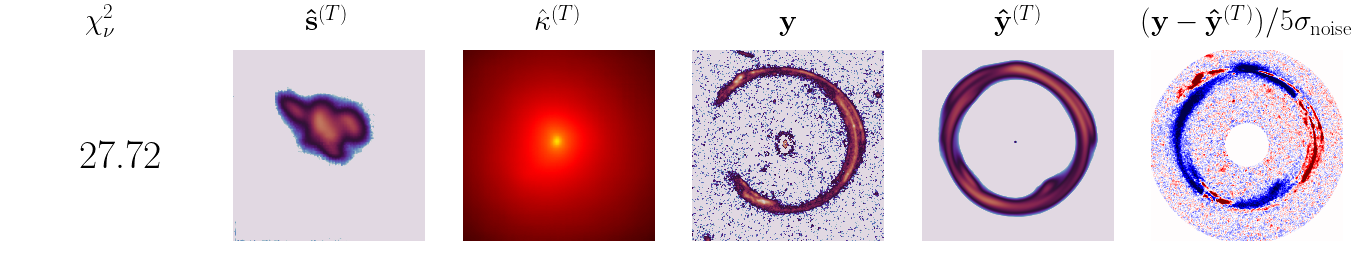

In [302]:
fig, axs = plt.subplots(1, 6, figsize=(24, 4))

axs[1].imshow(source[-1, 0, ..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")

axs[2].imshow(kappa[-1, 0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

axs[3].imshow(observation[-1, ..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[4].imshow(obs_pred[-1, ..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[5].imshow(mask*(observation - obs_pred)[0, ..., 0]/noise_rms/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")

axs[0].annotate(f"{2*chisq[-1, 0]:.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=40)
axs[0].set_title(r"$\chi^2_\nu$", pad=0, fontsize=30)
axs[1].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=30)
axs[2].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=30)
axs[3].set_title("$\mathbf{y}$", pad=20, fontsize=30)
axs[4].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=30)
axs[5].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=30)
for i in range(6):
    axs[i].axis("off")
plt.savefig("naked_rim_pred_on_horseshoe.png", facecolor="white")

In [278]:

header = fits.Header()
header["std_bkg"] = std_bkg
header["sky"] = bkg
header["exptime"] = exptime
header["noiserms"] = noise_rms.numpy()[0]
header["fov"] = FOV
header["srcfov"] = 4
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU(header=header))
new_hdul.append(fits.ImageHDU(data=rim_input1.numpy().squeeze(), name="rim_input"))
new_hdul.append(fits.ImageHDU(data=residual.squeeze(), name="galfit_observation"))
new_hdul.append(fits.ImageHDU(data=residual_temp.squeeze()/residual_temp.squeeze().max(), name="preprocessed_observation"))
new_hdul.append(fits.ImageHDU(data=im, name="raw_observation"))
new_hdul.append(fits.ImageHDU(data=mask1.numpy().squeeze(), name="mask"))
new_hdul.append(fits.ImageHDU(data=noise_std.squeeze(), name="sigma_image"))
new_hdul.append(fits.ImageHDU(data=psf1.numpy().squeeze(), name="psf"))
new_hdul.append(fits.ImageHDU(data=lens_light.numpy().squeeze(), name="lens_light"))
new_hdul.writeto("../data/horseshoe_rim_data.fits", overwrite=True)

In [370]:
data = fits.open("../data/horseshoe_rim_data.fits")
observation = tf.constant(data["preprocessed_observation"].data, dtype=tf.float32)[None, ..., None]  # galfitted, noise padded, normalized
# lens_light = tf.constant(data["lens_light"], dtype=tf.float32)[None, ..., None]
rim_input = tf.constant(data["rim_input"].data, dtype=tf.float32)[None, ..., None]
psf = tf.constant(data["psf"].data, dtype=tf.float32)[None, ..., None]
noise_rms = tf.constant(data["PRIMARY"].header["noiserms"])[None]
image_fov = data["PRIMARY"].header["fov"]
src_fov = data["PRIMARY"].header["srcfov"]
mask = tf.constant(data["mask"].data, dtype=tf.float32)[None, ..., None]
obs2 = data["galfit_observation"].data

# Optimize likelihood results

In [310]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "horseshoe_RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839.h5"), "r")

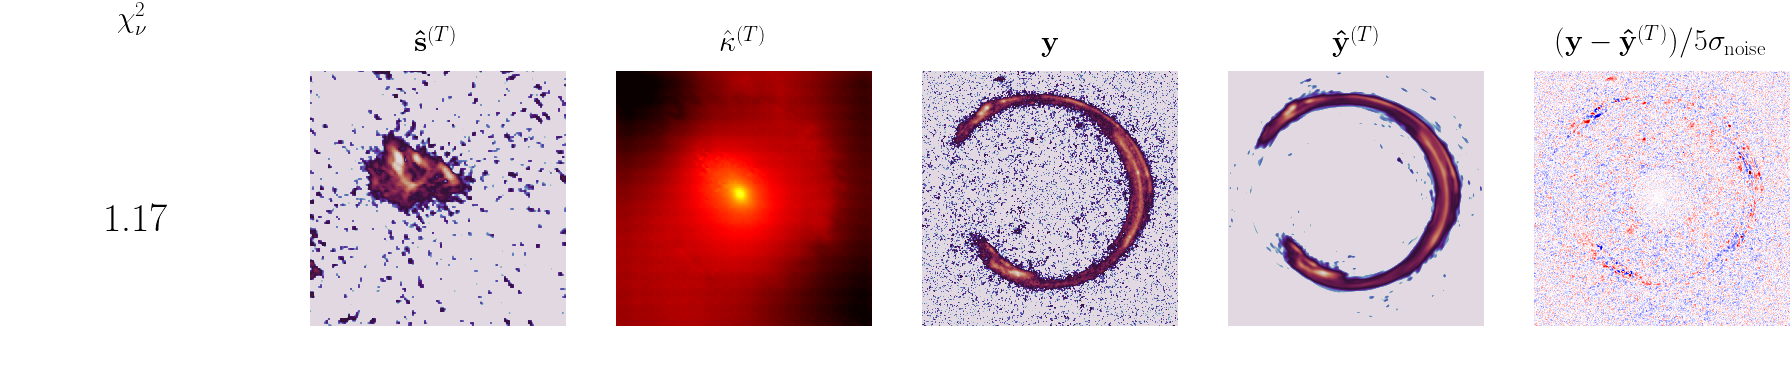

In [363]:
fig, axs = plt.subplots(1, 6, figsize=(32, 6))

axs[1].imshow(hf["source_rim_sgd"][-1], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")

axs[2].imshow(hf["kappa_rim_sgd"][-1], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

axs[3].imshow(observation[-1, ..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[4].imshow(hf["reconstruction_rim_sgd"][-1], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[5].imshow(residual_temp.max()*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_std/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")
 
axs[0].annotate(f"{np.mean(((observation[0, ..., 0] - hf['reconstruction_rim_sgd'][-1])/noise_rms)**2):.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=40)
axs[0].set_title(r"$\chi^2_\nu$", pad=0, fontsize=30)
axs[1].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=30)
axs[2].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=30)
axs[3].set_title("$\mathbf{y}$", pad=20, fontsize=30)
axs[4].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=30)
axs[5].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=30)
for i in range(6):
    axs[i].axis("off")
plt.savefig("optim_rim_pred_on_horseshoe.png", facecolor="white")

In [317]:
np.mean((mask[0, ..., 0]*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_rms)**2)

0.94695365

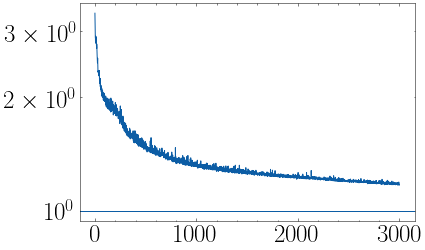

In [336]:
plt.plot(np.array(hf["chi_squared_series"])*128**2/350**2)
plt.axhline(1)
plt.yscale("log")

In [322]:
observation.shape

TensorShape([1, 350, 350, 1])

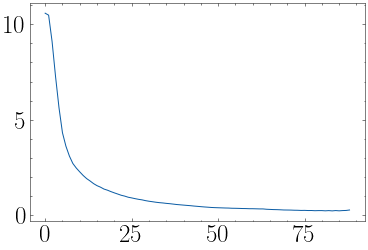

In [334]:
plt.plot(radial_profile(hf["kappa_rim_sgd"][-1], (128/2,)*2))

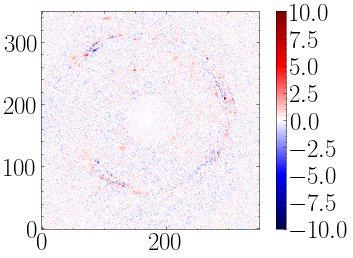

In [355]:
from matplotlib.colors import CenteredNorm
plt.imshow(residual_temp.max()*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_std, cmap="seismic", norm=CenteredNorm(), origin="lower")
plt.colorbar()

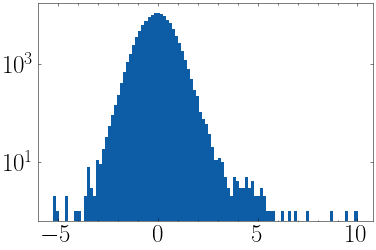

In [359]:
plt.hist((residual_temp.max()*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_std).numpy().ravel(), bins=100);
plt.yscale("log")
# plt.xlim(-10, 10)

In [361]:
((residual_temp.max()*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_std)**2).numpy().mean()

0.4986079

In [4]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "horseshoe10k_RIMSU128hstv4_augmented_003_K3_L5_BCL2_211124140837_continue_lr6e-05_211129202839.h5"), "r")

NameError: name 'observation' is not defined

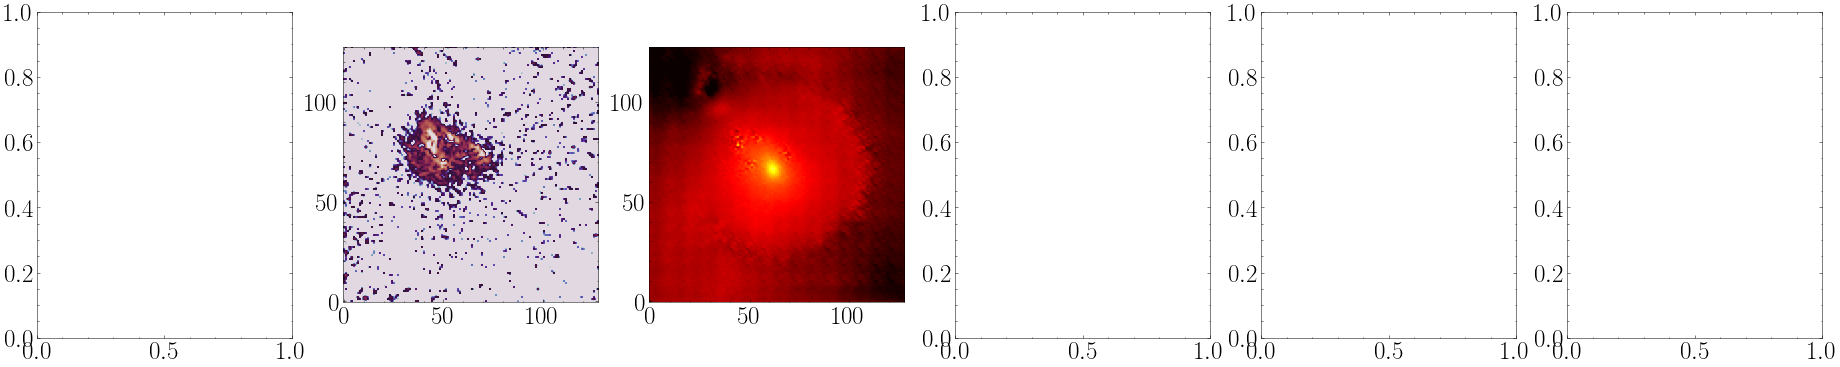

In [5]:
fig, axs = plt.subplots(1, 6, figsize=(32, 6))

axs[1].imshow(hf["source_rim_sgd"][-1], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")

axs[2].imshow(hf["kappa_rim_sgd"][-1], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

axs[3].imshow(observation[-1, ..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[4].imshow(hf["reconstruction_rim_sgd"][-1], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-2, vmax=1), origin="lower")
axs[5].imshow(residual_temp.max()*(observation[0, ..., 0] - hf["reconstruction_rim_sgd"][-1])/noise_std/5, cmap="seismic", vmin=-1, vmax=1, origin="lower")
 
axs[0].annotate(f"{np.mean(((observation[0, ..., 0] - hf['reconstruction_rim_sgd'][-1])/noise_rms)**2):.2f}", xy=(0.4, 0.4), xycoords="axes fraction", size=40)
axs[0].set_title(r"$\chi^2_\nu$", pad=0, fontsize=30)
axs[1].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=30)
axs[2].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=30)
axs[3].set_title("$\mathbf{y}$", pad=20, fontsize=30)
axs[4].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=30)
axs[5].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/5\sigma_{\mathrm{noise}}$", pad=20, fontsize=30)
for i in range(6):
    axs[i].axis("off")
plt.savefig("optim_rim_pred_on_horseshoe.png", facecolor="white")